In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import tensorflow.keras as keras

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('dark'))
plt.rcParams['figure.figsize'] = (20 , 20)

In [2]:
# !gdown 151WbWURL8IPXqhxi8vLCx7pmtvchegpZ --output ../data/
# !unzip ../data/PistolData_merged.zip -d ../data/
# !rm -R ../data/PistolData_merged.zip

In [3]:
import os
import cv2
datapath = '../../data/vision/PistolData_merged/'

annotfiles = sorted(os.listdir(f"{datapath}pistol_annotations"))
imagefiles = sorted(os.listdir(f"{datapath}pistol_images"))
imagefiles[:5]

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg']

In [4]:
img_h = 416
img_w = 416
def get_box(annotation):
    x , y , w , h = annotation[1] , annotation[2] , annotation[3] , annotation[4]
    x1 , y1 = int((x - w/2) * img_w) , int((y - h / 2) * img_h)
    x2 , y2 = int((x + w/2) * img_w) , int((y + h / 2) * img_h)

    return x1 , y1 , x2 , y2


def get_boxf(annotation):
    x , y , w , h = annotation[1] , annotation[2] , annotation[3] , annotation[4]
    x1 , y1 = float((x - w/2) * img_w) , float((y - h / 2) * img_h)
    x2 , y2 = float((x + w/2) * img_w) , float((y + h / 2) * img_h)

    return x1 , y1 , x2 , y2

def get_boxtf(annotation):
    x , y , w , h = annotation[1] , annotation[2] , annotation[3] , annotation[4]
    x = tf.cast(x , tf.float32)
    y = tf.cast(y , tf.float32)
    w = tf.cast(w , tf.float32)
    h = tf.cast(h , tf.float32)
    x1 , y1 = (x - w/2) * img_w , (y - h / 2) * img_h
    x2 , y2 = (x + w/2) * img_w , (y + h / 2) * img_h

    return x1 , y1 , x2 , y2

def plot_image(image , annotation):
    box = get_box(annotation)
    image = cv2.rectangle(image , (box[0] , box[1]) , (box[2] , box[3]) , (255,255,0), 3)
    plt.imshow(image)
    plt.axis('off')

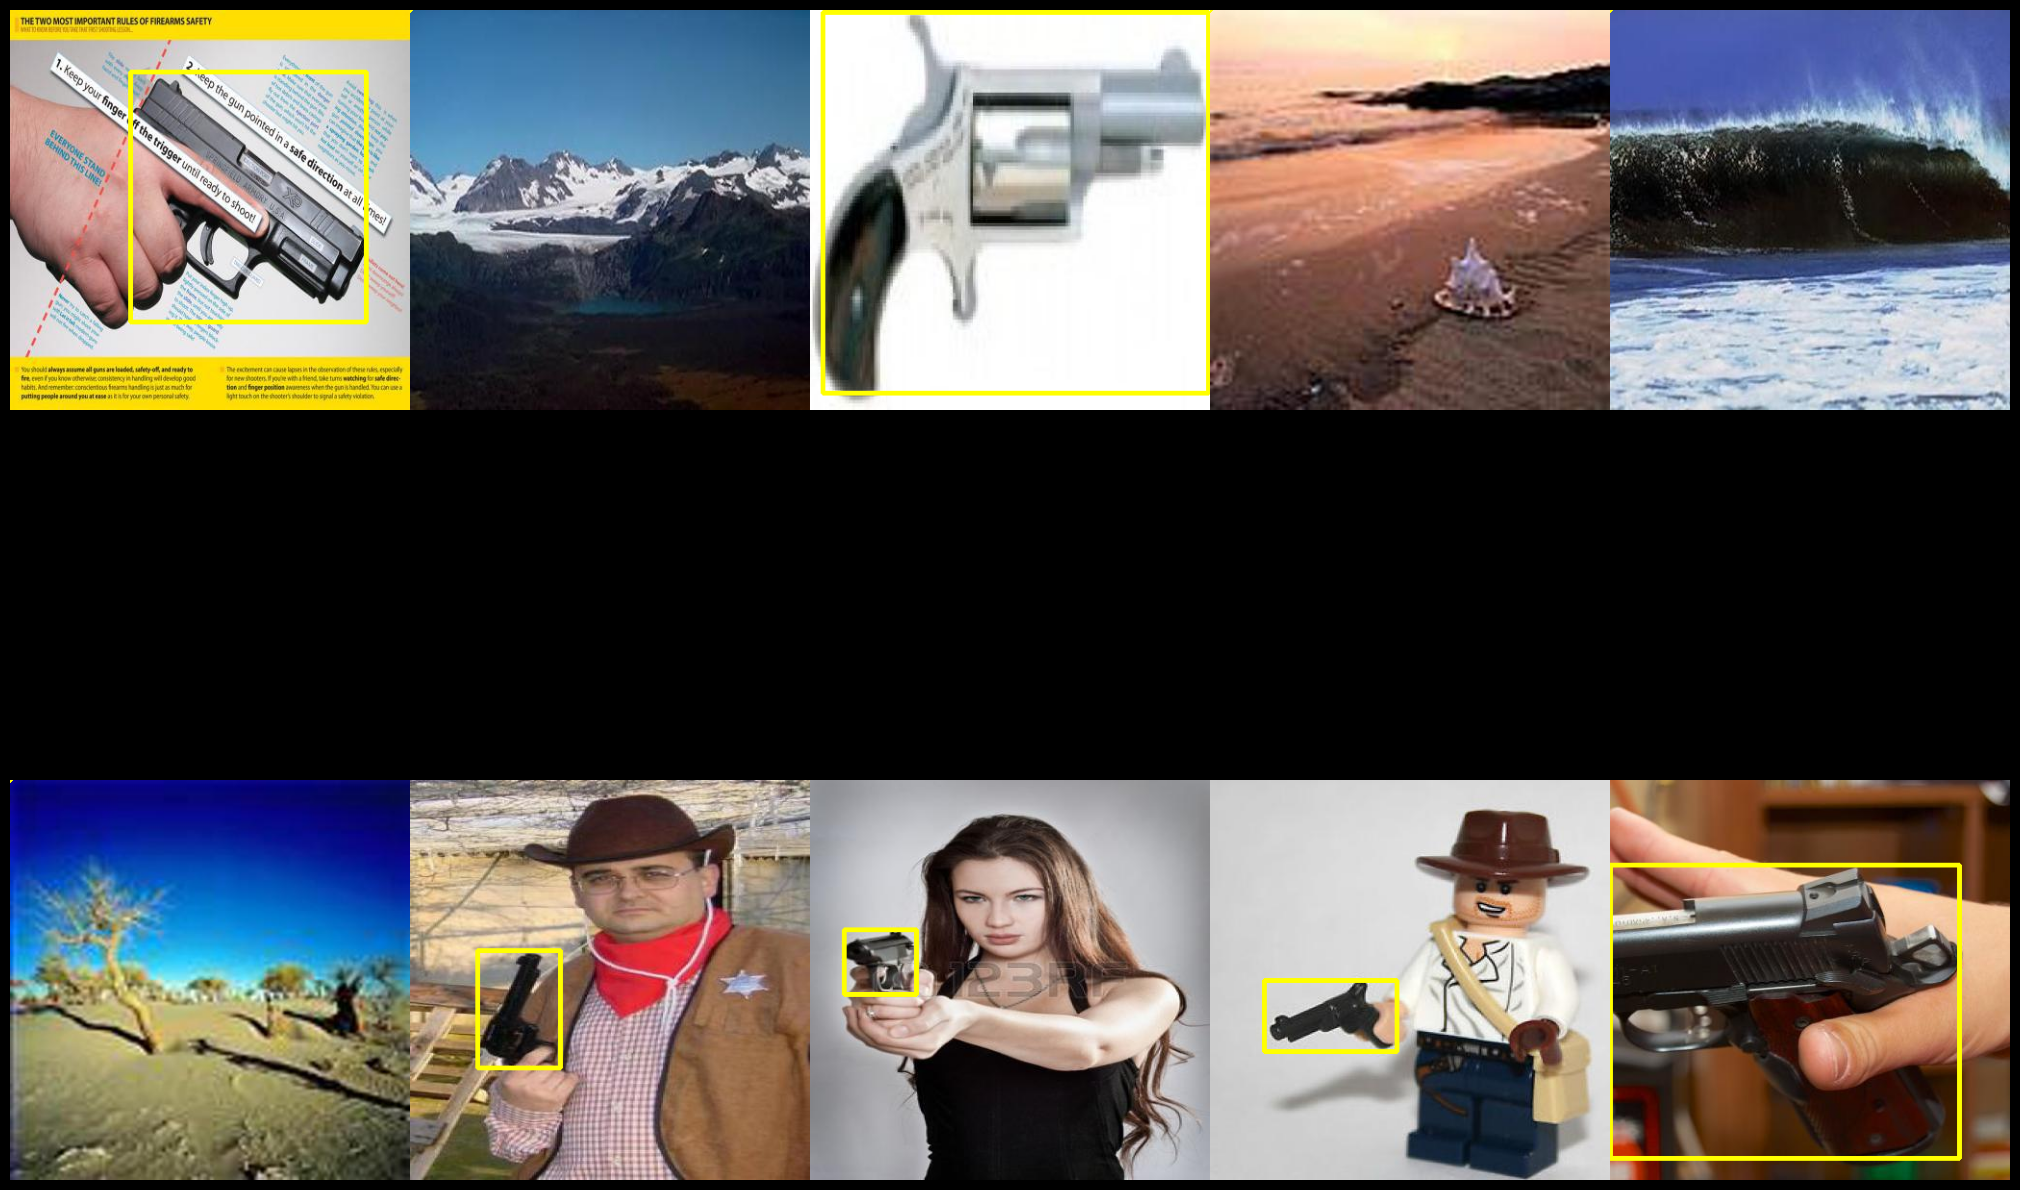

In [5]:
#plot sample images:


indices = np.random.randint(0 , len(imagefiles) , 10)

# plt.figure(figsize=(10 , 10))
for i , index in enumerate(indices):
    plt.subplot(2 , 5, i + 1)
    image = plt.imread(f"{datapath}pistol_images/{imagefiles[index]}")
    image = image.copy()
    annotationpath = f"{datapath}pistol_annotations/{annotfiles[index]}"
    # print(annotationpath , index , imagefiles[index])
    with open(annotationpath , 'r') as f:
        bbox = (f.readlines())
        annotation = [float(element) for element in bbox[0].split(' ')]
    plot_image(image , annotation)

plt.subplots_adjust(wspace= 0 , hspace = 0)
plt.tight_layout(pad = 0)

## load the dataset into arrays:

- array of images , classes and bounding boxes:


In [6]:
# fn to get annotations and class separately from each annotation file:
def segannot(file):
    with open(f'{datapath}pistol_annotations/{file}' , 'r') as f:
        content = f.readline()
    content = [float(el) for el in content.split()]
    return (content[0] , content[1:])

def getdata(imagefile , annotfile):
    image = plt.imread(f"{datapath}pistol_images/{imagefile}")
    cl , annotations = segannot(annotfile)
    return (True , image , cl , annotations)


images , classes , boxes = [] , [] , []
for file in annotfiles:
    imagefile = f"{file[:-4]}.jpg"
    afile = file
    status , image , clabel , bbox = getdata(imagefile , file)
    if status == True and image.shape == (416 , 416 , 3):
        images.append(image)
        classes.append(clabel)
        boxes.append(bbox)
images , classes , boxes = np.array(images) , np.array(classes) , np.array(boxes)
images.shape , classes.shape , boxes.shape

((3703, 416, 416, 3), (3703,), (3703, 4))

In [7]:
boxes[0]

array([0.42538462, 0.24479737, 0.22153846, 0.28148959])

In [8]:
# distribution of classes:
np.unique(classes , return_counts = True)

(array([0., 1.]), array([ 999, 2704]))

In [9]:
# divide model into train test split:
from sklearn.model_selection import train_test_split
ximage , xtimage , yclass , ytclass , ybox , ytbox = train_test_split(images , classes , boxes , test_size = 0.3 , random_state = 42) 
ximage.shape , xtimage.shape , yclass.shape , ytclass.shape , ybox.shape , ytbox.shape

((2592, 416, 416, 3),
 (1111, 416, 416, 3),
 (2592,),
 (1111,),
 (2592, 4),
 (1111, 4))

In [41]:
# create localization model using resnet101:
import tensorflow as tf
from tensorflow.keras.layers import Dense , Flatten , Input , GlobalAveragePooling2D

r101 = tf.keras.applications.ResNet101(weights = 'imagenet' , include_top= False , input_tensor = Input(shape = (416 , 416 , 3)))
for layer in r101.layers:
    layer.trainable = False

for l in r101.layers[-150:]:
    l.trainable = True
rout = r101.output
flat = GlobalAveragePooling2D()(rout)

#classification head:
x = Dense(128 , activation = 'relu')(flat)
x = Dense(64 , activation = 'relu')(x)
x = Dense(32 , activation = 'relu')(x)
cout = Dense(1 , activation = 'sigmoid' , name = 'class_output')(x)

#regression head:
x = Dense(128 , activation = 'relu')(flat)
# x = Dense(128 , activation = 'relu')(x)
x = Dense(64 , activation = 'relu')(x)
x = Dense(32 , activation = 'relu')(x)
rout = Dense(4 , activation = 'sigmoid' , name = 'box_output')(x)

model = tf.keras.models.Model(inputs = r101.input , outputs = [rout , cout])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 422, 422,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 208, 208,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 208, 208,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 208, 208,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 210, 210,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 104, 104,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 104, 104,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 104, 104,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 104, 104,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 104, 104,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 104, 104,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 104, 104,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 104, 104,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 104, 104,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 104, 104,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 104, 104,  │      1,024 │ conv2_block1_3_c

 Total params: 43,203,557 (164.81 MB)

 Trainable params: 28,683,109 (109.42 MB)

 Non-trainable params: 14,520,448 (55.39 MB)

In [11]:
# function to compute iou:
def iou(labelb , predb):
    gt = [0] * 4
    x1 , y1 , x2 , y2 = get_boxf(labelb)
    gt[0],gt[1],gt[2],gt[3] = x1,y1,x2,y2

    pred = [0,0,0,0]
    x1,y1,x2,y2=get_boxf(predb)
    pred[0],pred[1],pred[2],pred[3] = x1,y1,x2,y2
    print(f"{gt=} , {pred=}")

    ileft = [max(gt[0] , pred[0]) , max(gt[1] , pred[1])]
    iright = [min(gt[2] , pred[2]) , min(gt[3] , pred[3])]

    print(f"{ileft=} , {iright=}")

    iw = max(0 , iright[0] - ileft[0])
    ih = max(0 , iright[1] - ileft[1])

    intersection = iw * ih
    garea = (gt[2] - gt[0]) * (gt[3] - gt[1])
    parea = (pred[2] - pred[0]) * (pred[3] - pred[1])
    union = garea + parea - intersection
    print(f"{garea=} , {parea=}")
    print(f"{intersection=} , {union=}")
    iou = intersection / union
    return iou


def tf_iou(labelb , predb):
    gt = [0] * 4
    x1 , y1 , x2 , y2 = get_boxtf(labelb)
    gt[0],gt[1],gt[2],gt[3] = x1,y1,x2,y2

    pred = [0,0,0,0]
    x1,y1,x2,y2=get_boxtf(predb)
    pred[0],pred[1],pred[2],pred[3] = x1,y1,x2,y2

    ileft = [tf.maximum(gt[0] , pred[0]) , tf.maximum(gt[1] , pred[1])]
    iright = [tf.minimum(gt[2] , pred[2]) , tf.minimum(gt[3] , pred[3])]


    iw = tf.maximum(0.0 , iright[0] - ileft[0])
    ih = tf.maximum(0.0 , iright[1] - ileft[1])

    intersection = iw * ih
    garea = (gt[2] - gt[0]) * (gt[3] - gt[1])
    parea = (pred[2] - pred[0]) * (pred[3] - pred[1])
    union = garea + parea - intersection

    iou = intersection / (union + 1e-6)
    return iou

def iou_loss(lbox , pbox):
    return 1.0 - tf.reduce_mean(tf_iou(lbox , pbox))

In [12]:
losses = {
    'class_output' : 'binary_crossentropy',
    'box_output': tf.keras.losses.Huber(delta=0.4)
}

loss_weights = {
    'box_output' : 15.0,
    'class_output' : 1.0
}

metrics = {
    'box_output' : tf_iou,
    'class_output' : 'accuracy'
}

opt = tf.keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer = opt , loss = losses , loss_weights = loss_weights , metrics = metrics)

In [13]:
logdir = './models/localization'
!rm -rf logdir
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# start training the model
history = model.fit(x= ximage , y={"class_output":yclass, "box_output":ybox},
                              validation_data=( xtimage , {"class_output":ytclass, "box_output":ytbox}),
                              batch_size=32,
                              epochs=10,
                              callbacks=(tensorboard_callback)
                           )
model.save('./models/localization/resnet_modified.keras')

Epoch 1/10


2026-01-04 18:15:02.365763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


81/81 ━━━━━━━━━━━━━━━━━━━━ 94s 885ms/step - box_output_loss: 0.0274 - box_output_tf_iou: 0.1325 - class_output_accuracy: 0.8952 - class_output_loss: 0.1803 - loss: 0.5910 - val_box_output_loss: 0.0487 - val_box_output_tf_iou: 0.0866 - val_class_output_accuracy: 0.9955 - val_class_output_loss: 0.0136 - val_loss: 0.7426
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 798ms/step - box_output_loss: 0.0216 - box_output_tf_iou: 0.2055 - class_output_accuracy: 0.9979 - class_output_loss: 0.0120 - loss: 0.3354 - val_box_output_loss: 0.0219 - val_box_output_tf_iou: 0.1315 - val_class_output_accuracy: 0.9937 - val_class_output_loss: 0.0458 - val_loss: 0.3742
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 64s 796ms/step - box_output_loss: 0.0127 - box_output_tf_iou: 0.2023 - class_output_accuracy: 0.9988 - class_output_loss: 0.0107 - loss: 0.2009 - val_box_output_loss: 0.0474 - val_box_output_tf_iou: 0.0843 - val_class_output_accuracy: 0.9802 - val_class_output_loss: 0.1678 - val_loss: 0.8797
Epoch 4/10
81/81 ━

## inference and evaluation:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Actual annotation:[1.         0.39240506 0.64042553 0.50632911 0.48085106]
Predicted annotation:[0.89516133 0.31039318 0.70431507 0.5133888  0.44880345]
gt=[57.9240506329114, 166.4, 268.5569620253164, 366.4340425531915] , pred=[22.33869171142578, 199.64394903182983, 235.90843772888184, 386.34618616104126]
ileft=[57.9240506329114, 199.64394903182983] , iright=[235.90843772888184, 366.4340425531915]
garea=42133.752760570955 , parea=39873.94936457654
intersection=29686.03256907914 , union=52321.66955606836
iou:0.5673754836371826
[0.89516133 0.31039318 0.70431507 0.5133888  0.44880345]


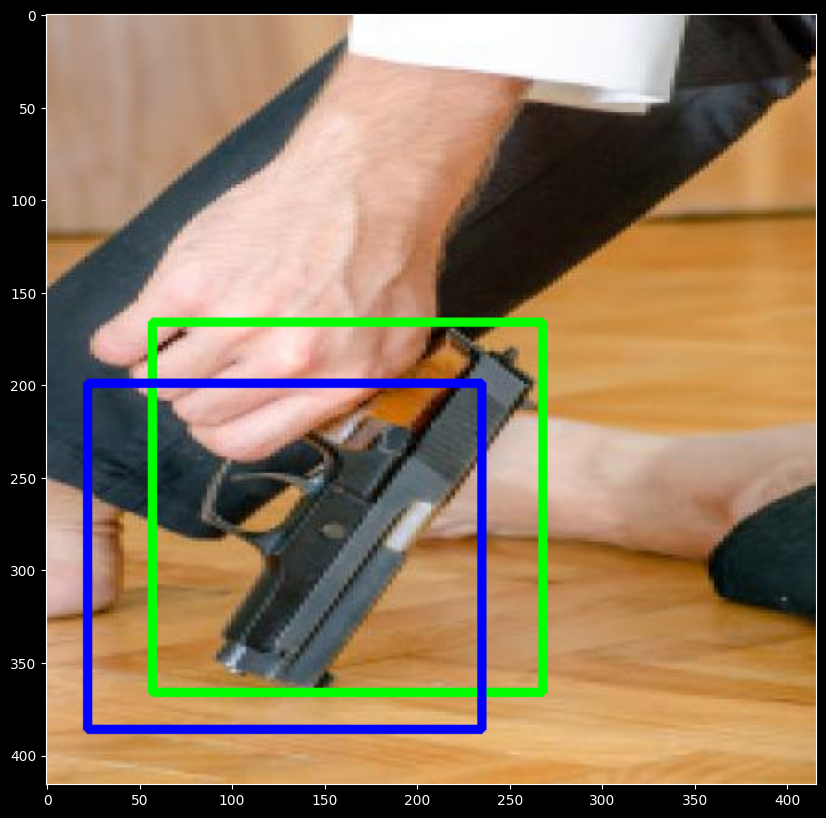

In [59]:
# function to plot predicted box along with actual box:

def predict(image , model , mode = 'single'):
    if mode == 'single':
        image = np.expand_dims(image , axis = 0)
        box , cl = model.predict(image)
        return box[0] , cl[0]
    box , cl = model.predict(image)
    return box , cl
def plotPredictedImage(image , annotation , pannotation):
    print(f"{pannotation}")
    box = get_box(annotation)
    pbox = get_box(pannotation)
    image = image.copy()
    image = cv2.rectangle(image , (box[0] , box[1]) , (box[2] , box[3]) , (0 , 255 , 0) , 3)
    image = cv2.rectangle(image , (pbox[0] , pbox[1]) , (pbox[2] , pbox[3]) , (0 , 0 , 255) , 3)
    plt.figure(figsize=(10 , 10))
    plt.clf()
    plt.cla()
    plt.imshow(image)
    plt.show()
    plt.close('all')


i = np.random.randint(600)
# np.concatenate([ytclass.reshape(-1 , 1) , ytbox] , axis = 1)[i] , np.concatenate([cl[0] , pannotation[0]])
box , cl = predict(xtimage[i] , model)
annot = np.concatenate([ytclass.reshape(-1 , 1) , ytbox] , axis = 1)
annot = annot[i]
pannot = np.concatenate([cl , box])
print(f"Actual annotation:{annot}")
print(f"Predicted annotation:{pannot}")
print(f"iou:{iou(annot , pannot)}")
plotPredictedImage(xtimage[i] , annot , pannot)

In [49]:
model.predict(xtimage[0:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


[array([[0.05226226, 0.90162635, 0.6567022 , 0.12130951]], dtype=float32),
 array([[0.21867472]], dtype=float32)]